In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
DIRECTORY = 'drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_08/'

In [4]:
!cp drive/MyDrive/Informatics/Sphere@mail.ru/NN/hw_08/*.csv .

## Семинар 9: "LSTM"

ФИО: Иванов Максим Юрьевич

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
from IPython.display import clear_output
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

In [ ]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

NameError: ignored

In [ ]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size:], dataset[train_size:len(dataset):]
right_data = np.hstack((train[:, 0], test[:, 0]))
print(len(train), len(test))

96 48


In [ ]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1 - look_forward):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [ ]:
# Пример подготовленных данных

look_back = 16
look_forward = 1
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
batch_size = 1

In [ ]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = TensorDataset(torch.from_numpy(testX), torch.from_numpy(testY))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
for X, y in train_dataloader:
    print(X)
    print(y)
    break

tensor([[[0.0154, 0.0270, 0.0541, 0.0483, 0.0328, 0.0598, 0.0849, 0.0849,
          0.0618, 0.0290, 0.0000, 0.0270, 0.0212, 0.0425, 0.0714, 0.0598]]])
tensor([[0.0405]])


#### Train func

In [ ]:
class NeuralNetworkWrapper:

    def __init__(self, network_name, *network_args, **network_kwargs):
        self.current_epoch = 0
        self.network = network_name(*network_args, **network_kwargs)
        self.first = True

        self.network_name = network_name
        self.network_args = network_args
        self.network_kwargs = network_kwargs
    
    def null_network(self):
        self.network = self.network_name(*self.network_args, **self.network_kwargs)
        self.current_epoch = 0
        self.first = True
    
    def _epoch(self, loader, backward=True, ravel_init=False):
        loss = self.loss
        optimizer = self.optimizer
        device = self.device
        network = self.network
        losses = []
        hidden = None

        for X, y in loader:
            hidden = hidden or \
                    (Variable(torch.zeros(1, X.size(1), self.network.hidden_size)).to(device),
                     Variable(torch.zeros(1, X.size(1), self.network.hidden_size)).to(device))
            X = X.to(device)
            y = y.to(device)
            if ravel_init:
                X = X.view(X.size(0), -1)
            network.zero_grad()
            prediction, hidden = network(X, hidden)
            hidden[0].detach_()
            hidden[1].detach_()
            prediction = prediction.reshape(-1, 1)
            loss_batch = loss(prediction, y)
            losses.append(loss_batch.cpu().item())
            if backward:
                loss_batch.backward()
                optimizer.step()
        return losses
    
    def fit(self, train_loader=None, test_loader=None, epochs=10, 
          learning_rate=1e-3, plot=True, verbose=True, loss=None, 
          optimizer=None, clear_data=True, get_loaders_func=None,
          ravel_init=False, device='cpu', tolerate_keyboard_interrupt=True,
          need_return=False):
        
        if self.first:
            self.loss = loss() if loss else nn.NLLLoss()
            self.optimizer = optimizer(self.network.parameters(), learning_rate) if optimizer else torch.optim.Adam(self.network.parameters(), lr=learning_rate)
            self.device = device
            self.train_loss_epochs = []
            self.test_loss_epochs = []

            self.network = self.network.to(device)
        
        loss = self.loss
        optimizer = self.optimizer
        network = self.network
        train_loss_epochs = self.train_loss_epochs
        test_loss_epochs = self.test_loss_epochs
        
        if train_loader is None and get_loaders_func is None:
            raise RuntimeError("No train_loader")

        self.first = False

        try:
            for epoch in range(self.current_epoch, epochs):
                if get_loaders_func:
                    train_loader, test_loader = get_loaders_func()
                if train_loader:
                    network.train()
                    losses = self._epoch(train_loader, True, ravel_init)
                    self.current_epoch += 1
                    train_loss_epochs.append(np.mean(losses))
                if test_loader:
                    network.eval()
                    losses = self._epoch(test_loader, False, ravel_init)
                    test_loss_epochs.append(np.mean(losses))
                
                if verbose and epoch % 10 == 0:
                    if clear_data:
                        clear_output(True)
                    if test_loader:
                        print('Epoch {0}... (Train/Test) Loss: {1:.3f}/{2:.3f}'.format(
                                epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
                    else:
                        print('Epoch {0}... (Train) Loss: {1:.3f}'.format(
                                epoch, train_loss_epochs[-1]))
                
                if plot and epoch % 10 == 0:
                    plt.figure(figsize=(12, 5))
                    #plt.subplot(1, 2, 1)
                    plt.plot(train_loss_epochs, label='Train')
                    if test_loader:
                        plt.plot(test_loss_epochs, label='Test')
                    plt.xlabel('Epochs', fontsize=16)
                    plt.ylabel('Loss', fontsize=16)
                    plt.legend(loc=0, fontsize=16)
                    plt.grid()
                    plt.show()

        except KeyboardInterrupt:
            if tolerate_keyboard_interrupt:
                pass
            else:
                raise KeyboardInterrupt
        if need_return:
            return train_loss_epochs, test_loss_epochs
    
    def predict(self, loader, ravel_init=False, device='cpu'):
        network = self.network
        network.eval()
        with torch.no_grad():
            pred = []
            for X, y in loader:
                X = X.to(device)
                y = y.to(device)
                if ravel_init:
                    X = X.view(X.size(0), -1)
                network.zero_grad()
                prediction = network(X)
                pred.append(prediction)
        return pred

### My LSTM

In [ ]:
class LSTMWrapper(nn.Module):
    def __init__(self, model, input_size, hidden_size):
        super(LSTMWrapper, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = model(input_size, hidden_size)
        self.linear = nn.Linear(self.hidden_size, 1)

    def forward(self, X, hidden):
        batch_size = X.size(1)
        
        out, hidden = self.lstm(X, hidden)
        out = self.linear(out)
        return out, hidden

In [ ]:
networks = {
    'My': NeuralNetworkWrapper(LSTMWrapper, LSTM, look_back, look_forward),
    'Torch': NeuralNetworkWrapper(LSTMWrapper, nn.LSTM, look_back, look_forward)
}

In [ ]:
epochs = 1500

Epoch 570... (Train/Test) Loss: 0.000/0.009


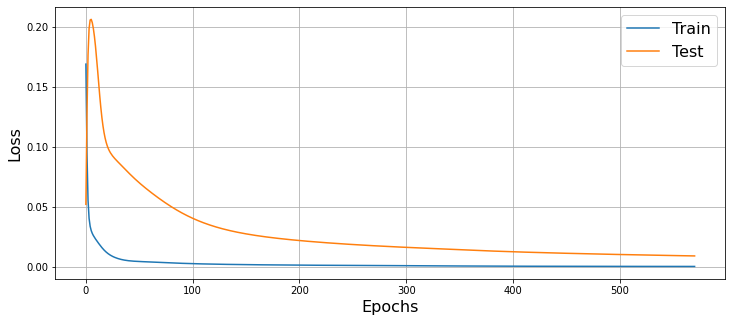

In [ ]:
networks['My'].fit(train_dataloader, test_dataloader, loss=nn.MSELoss, epochs=epochs)

Epoch 560... (Train/Test) Loss: 0.000/0.006


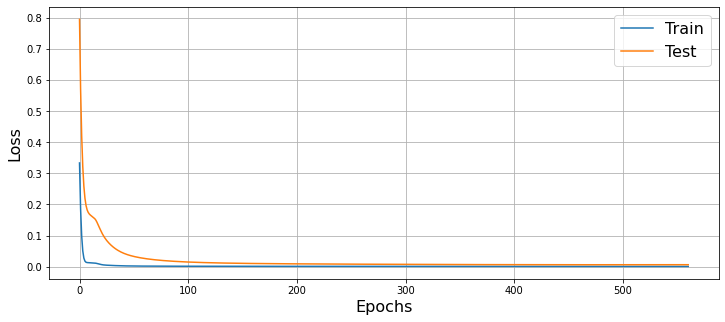

In [ ]:
networks['Torch'].fit(train_dataloader, test_dataloader, loss=nn.MSELoss, epochs=epochs)

In [ ]:
def predict(network):
    network = network.network
    network.eval()
    with torch.no_grad():
        pred = []
        hidden = None
        for X, y in train_dataloader:
            hidden = hidden or \
                    (Variable(torch.zeros(1, X.size(1), network.hidden_size)),
                     Variable(torch.zeros(1, X.size(1), network.hidden_size)))
        
        while len(pred) != test_size:
            network.zero_grad()
            prediction, hidden = network(X, hidden)
            prediction = [elem.item() for elem in prediction[:, 0, 0]]
            pred += prediction[-1:]
            for i in range(X.size(2) - 1):
                for j in range(X.size(0)):
                    X[j, 0, i] = X[j, 0, i + 1]
            for j in range(X.size(0)):
                X[j, 0, -1] = prediction[j]

    plt.figure(figsize=(12, 5))
    plt.plot(right_data[-len(pred):], label='true')
    plt.plot(pred, label='predicted')
    plt.legend()
    plt.show()

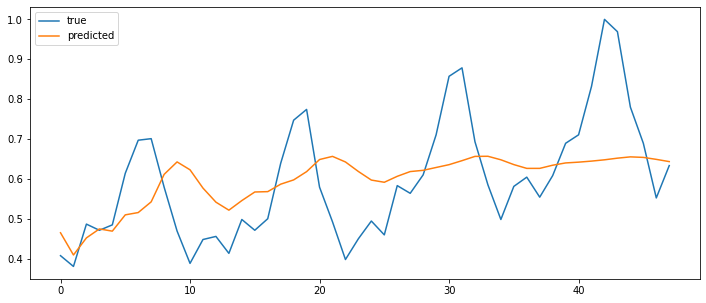

In [ ]:
predict(networks['My'])

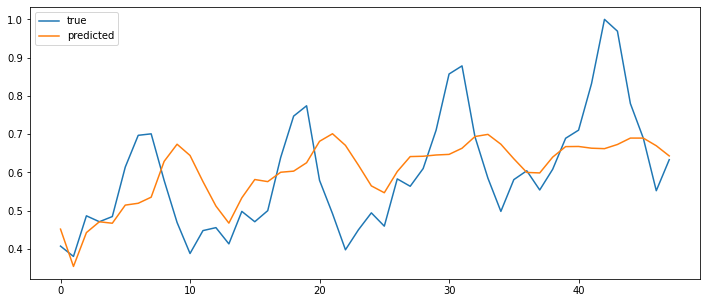

In [ ]:
predict(networks['Torch'])

## Задание 3 

Поучаствуйте в соревновании https://www.kaggle.com/t/374fc477c4744b009a837153ce135cfb 

Для зачета задания нужно получить значение MAPE меньше 0.2

До 1 мая 2021 можно получить 3,2,1 дополнительных балла за 1, 2 и 3 место соответственно.


Опиционально: сравните классические подходы (ARIMA, gradient boosting trees и RNN)

In [61]:
dataset = pandas.read_csv('train.csv')

In [62]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1096 non-null   object
 1   hits    1096 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 17.2+ KB


In [63]:
dataset.head()

,date,hits
0,2016-01-01,201979088
1,2016-01-02,223095158
2,2016-01-03,233791442
3,2016-01-04,259684220
4,2016-01-05,267112490


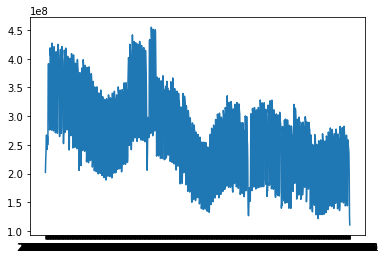

In [64]:
plt.plot(dataset.date, dataset.hits)

In [65]:
dataset = dataset.hits.values.reshape(-1, 1)

In [66]:
dataset_right = dataset

In [67]:
# dataset2 = pandas.read_csv('best_submission_28.csv')
# dataset2 = dataset2.hits.values.reshape(-1, 1)
# dataset = np.vstack((dataset, dataset2))

In [68]:
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [164]:
train_size = int(len(dataset) * 0.95)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size:], dataset[train_size:len(dataset):]
right_data = np.hstack((train[:, 0], test[:, 0]))
print(len(train), len(test))

1041 55


In [165]:
def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1 - look_forward):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [166]:
look_back = 14
look_forward = 1
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

allX, allY = create_dataset(dataset, look_back, look_forward)
allX = np.reshape(allX, (allX.shape[0], 1, allX.shape[1]))

In [167]:
batch_size = 5

In [168]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)

test_dataset = TensorDataset(torch.from_numpy(testX), torch.from_numpy(testY))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

all_dataset = TensorDataset(torch.from_numpy(allX), torch.from_numpy(allY))
all_dataloader = DataLoader(all_dataset, batch_size=batch_size)

### Funcs

In [169]:
class NeuralNetworkWrapper:

    def __init__(self, network_name, *network_args, **network_kwargs):
        self.current_epoch = 0
        self.network = network_name(*network_args, **network_kwargs)
        self.first = True

        self.network_name = network_name
        self.network_args = network_args
        self.network_kwargs = network_kwargs
    
    def null_network(self):
        self.network = self.network_name(*self.network_args, **self.network_kwargs)
        self.current_epoch = 0
        self.first = True
    
    def _epoch(self, loader, backward=True, ravel_init=False, teacher_forcing=True):
        loss = self.loss
        optimizer = self.optimizer
        device = self.device
        network = self.network
        losses = []
        for X, y in loader:
            break
        hidden = (Variable(torch.zeros(1, X.size(1), self.network.hidden_size)).to(device),
                  Variable(torch.zeros(1, X.size(1), self.network.hidden_size)).to(device))
        hidden_gru = Variable(torch.zeros(1, X.size(1), self.network.hidden_size)).to(device)
        X_pred = None

        for X, y in loader:
            if teacher_forcing or X_pred is None:
                X_pred = X
            X_pred = X.to(device)
            y = y.to(device)
            if ravel_init:
                X = X.view(X.size(0), -1)
            network.zero_grad()
            prediction, hidden, hidden_gru = network(X, hidden, hidden_gru)
            prediction_list = [elem.item() for elem in prediction[:, 0, 0]]
            prediction = prediction.reshape(-1, 1)
            loss_batch = loss(prediction, y)
            losses.append(loss_batch.cpu().item())
            if backward:
                loss_batch.backward()
                optimizer.step()
            hidden[0].detach_()
            hidden[1].detach_()
            hidden_gru.detach_()


            if not teacher_forcing:
                for i in range(X_pred.size(2) - 1):
                    for j in range(X_pred.size(0)):
                        X_pred[j, 0, i] = X_pred[j, 0, i + 1]
                for j in range(X.size(0)):
                    X_pred[j, 0, -1] = prediction_list[j]


        return losses
    
    def fit(self, train_loader=None, test_loader=None, epochs=10, 
          learning_rate=1e-4, plot=True, verbose=True, loss=None, 
          optimizer=None, clear_data=True, get_loaders_func=None,
          ravel_init=False, device='cpu', tolerate_keyboard_interrupt=True,
          need_return=False, plot_wait=False, verbose_every=10,
          teacher_forcing=True):
        
        if self.first:
            self.loss = loss() if loss else nn.NLLLoss()
            self.optimizer = optimizer(self.network.parameters(), learning_rate) if optimizer else torch.optim.Adam(self.network.parameters(), lr=learning_rate)
            self.device = device
            self.train_loss_epochs = []
            self.test_loss_epochs = []

            self.network = self.network.to(device)
        
        loss = self.loss
        optimizer = self.optimizer
        network = self.network
        train_loss_epochs = self.train_loss_epochs
        test_loss_epochs = self.test_loss_epochs
        
        if train_loader is None and get_loaders_func is None:
            raise RuntimeError("No train_loader")

        self.first = False

        try:
            for epoch in range(self.current_epoch, epochs):
                if get_loaders_func:
                    train_loader, test_loader = get_loaders_func()
                if train_loader:
                    network.train()
                    losses = self._epoch(train_loader, True, ravel_init, teacher_forcing)
                    self.current_epoch += 1
                    train_loss_epochs.append(np.mean(losses))
                if test_loader:
                    network.eval()
                    losses = self._epoch(test_loader, False, ravel_init, teacher_forcing)
                    test_loss_epochs.append(np.mean(losses))
                
                if verbose and epoch % verbose_every == 0:
                    if clear_data:
                        clear_output(True)
                    if test_loader:
                        print('Epoch {0}... (Train/Test) Loss: {1:.3f}/{2:.3f}'.format(
                                epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
                    else:
                        print('Epoch {0}... (Train) Loss: {1:.3f}'.format(
                                epoch, train_loss_epochs[-1]))
                
                if plot and epoch % verbose_every == 0:
                    plt.figure(figsize=(12, 5))
                    #plt.subplot(1, 2, 1)
                    plt.plot(train_loss_epochs, label='Train')
                    if test_loader:
                        plt.plot(test_loss_epochs, label='Test')
                    plt.xlabel('Epochs', fontsize=16)
                    plt.ylabel('Loss', fontsize=16)
                    plt.legend(loc=0, fontsize=16)
                    plt.grid()
                    plt.show()

                    predict(self)
                    make_submission(self)
                    if plot_wait:
                        time.sleep(5)

        except KeyboardInterrupt:
            if tolerate_keyboard_interrupt:
                pass
            else:
                raise KeyboardInterrupt
        if need_return:
            return train_loss_epochs, test_loss_epochs
    
    def predict(self, loader, ravel_init=False, device='cpu'):
        network = self.network
        network.eval()
        with torch.no_grad():
            pred = []
            for X, y in loader:
                X = X.to(device)
                y = y.to(device)
                if ravel_init:
                    X = X.view(X.size(0), -1)
                network.zero_grad()
                prediction = network(X)
                pred.append(prediction)
        return pred

In [170]:
def predict(network):
    network = network.network
    network.eval()
    with torch.no_grad():
        pred = []
        for X, y in all_dataloader:
            break
        hidden = (Variable(torch.zeros(1, X.size(1), network.hidden_size)),
                  Variable(torch.zeros(1, X.size(1), network.hidden_size)))
        hidden_gru = Variable(torch.zeros(1, X.size(1), network.hidden_size))
        for X, y in train_dataloader:
            network.zero_grad()
            prediction, hidden, hidden_gru = network(X, hidden, hidden_gru)

        while len(pred) != test_size:
            network.zero_grad()
            prediction, hidden, hidden_gru = network(X, hidden, hidden_gru)
            prediction = [elem.item() for elem in prediction[:, 0, 0]]
            pred += prediction[-1:]
            for i in range(X.size(2) - 1):
                for j in range(X.size(0)):
                    X[j, 0, i] = X[j, 0, i + 1]
            for j in range(X.size(0)):
                X[j, 0, -1] = prediction[j]

    plt.figure(figsize=(12, 5))
    plt.plot(right_data[-len(pred):], label='true')
    plt.plot(pred, label='predicted')
    plt.legend()
    plt.show()

In [171]:
def make_submission(network):
    network = network.network
    network.eval()
    with torch.no_grad():
        pred = []
        for X, y in all_dataloader:
            break
        hidden = (Variable(torch.zeros(1, X.size(1), network.hidden_size)),
                  Variable(torch.zeros(1, X.size(1), network.hidden_size)))
        hidden_gru = Variable(torch.zeros(1, X.size(1), network.hidden_size))
        for X, y in all_dataloader:
            network.zero_grad()
            prediction, hidden, hidden_gru = network(X, hidden, hidden_gru)
        
        while len(pred) != 365:
            network.zero_grad()
            prediction, hidden, hidden_gru = network(X, hidden, hidden_gru)
            prediction = [elem.item() for elem in prediction[:, 0, 0]]
            pred += [prediction[-1:][0]]
            for i in range(X.size(2) - 1):
                for j in range(X.size(0)):
                    X[j, 0, i] = X[j, 0, i + 1]
            for j in range(X.size(0)):
                X[j, 0, -1] = prediction[j]

    pred = scaler.inverse_transform(np.array(pred).reshape(-1, 1))
    x = range(dataset_right.reshape(-1).size)
    x_next = range(dataset_right.reshape(-1).size, dataset_right.reshape(-1).size + 365)

    plt.figure(figsize=(12, 5))
    plt.plot(x, dataset_right)
    plt.plot(x_next, pred)
    plt.show()

    return pred

In [172]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.gru = nn.GRU(input_size, hidden_size)
        self.linear = nn.Linear(self.hidden_size * 2, output_size)

    def forward(self, X, hidden, hidden_gru):
        out_1, hidden = self.lstm(X, hidden)
        out_2, hidden_gru = self.gru(X, hidden_gru)
        out = torch.cat((out_1, out_2), dim=-1)
        out = self.linear(out)
        return out, hidden, hidden_gru

In [173]:
class MAPELoss(nn.L1Loss):
    def forward(self, y_pred, target):
        target = target.reshape(-1, 1)
        y_pred = y_pred / (target.abs() + 1e-8)
        target = target / (target.abs() + 1e-8)
        loss = super().forward(y_pred, target)
        loss = 100 * loss
        return loss

### Sol

In [179]:
network = NeuralNetworkWrapper(NeuralNetwork, look_back, 100, look_forward)

In [180]:
epochs = 1000

Epoch 990... (Train/Test) Loss: 9.578/24.512


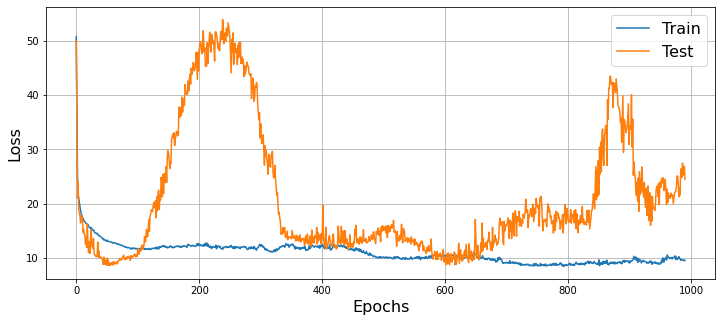

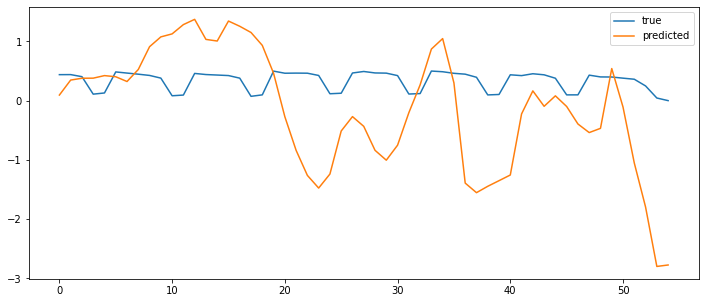

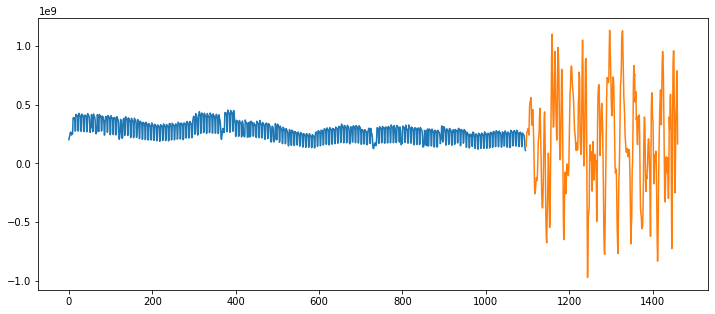

In [181]:
network.fit(train_dataloader, test_dataloader, loss=MAPELoss, epochs=epochs,
            plot_wait=False, verbose_every=10, teacher_forcing=False)

### Submission

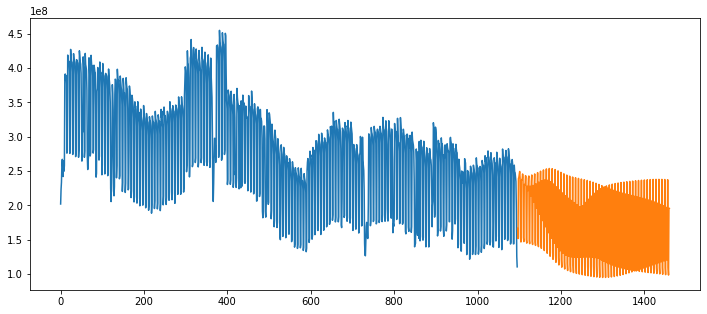

In [ ]:
pred = make_submission(network)

In [ ]:
submission = pandas.read_csv('sample_submission.csv')

In [ ]:
submission.hits = pred

In [ ]:
import time

In [ ]:
name = time.asctime() + '_submission.csv'
submission.to_csv(name, index=False)

In [ ]:
!rm "$name"

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: